In [ ]:
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn functions
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

#Widgets
import ipywidgets as widgets
from ipywidgets import interact_manual, fixed

import utils

# Look into the data and process

In [ ]:
# Importing data
df = pd.read_csv("data/world_happiness.csv")

In [ ]:
print (df.columns)
#We need to refine columns names which contain strings
df.columns = ["_".join(i.split(" ")).lower() for i in df.columns]

Index(['Country name', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect'],
      dtype='object')


In [ ]:
print("Percentage of NANs:\n\n", round(df.isna().sum()/df.shape[0] * 100, 2))

Percentage of NANs:

 country_name                        0.00
year                                0.00
life_ladder                         0.00
log_gdp_per_capita                  1.18
social_support                      0.55
healthy_life_expectancy_at_birth    2.67
freedom_to_make_life_choices        1.52
generosity                          3.43
perceptions_of_corruption           5.29
positive_affect                     1.02
negative_affect                     0.68
dtype: float64


In [ ]:
df = df.dropna()
df.head()

country_name  year  life_ladder  log_gdp_per_capita  social_support  \
0  Afghanistan  2008        3.724               7.350           0.451   
1  Afghanistan  2009        4.402               7.509           0.552   
2  Afghanistan  2010        4.758               7.614           0.539   
3  Afghanistan  2011        3.832               7.581           0.521   
4  Afghanistan  2012        3.783               7.661           0.521   

   healthy_life_expectancy_at_birth  freedom_to_make_life_choices  generosity  \
0                              50.5                         0.718       0.164   
1                              50.8                         0.679       0.187   
2                              51.1                         0.600       0.118   
3                              51.4                         0.496       0.160   
4                              51.7                         0.531       0.234   

   perceptions_of_corruption  positive_affect  negative_affect  
0                      0.882            0.414            0.258  
1                      0.850            0.481            0.237  
2                      0.707            0.517            0.275  
3                      0.731            0.480            0.267  
4                      0.776            0.614            0.268

# Data inspection

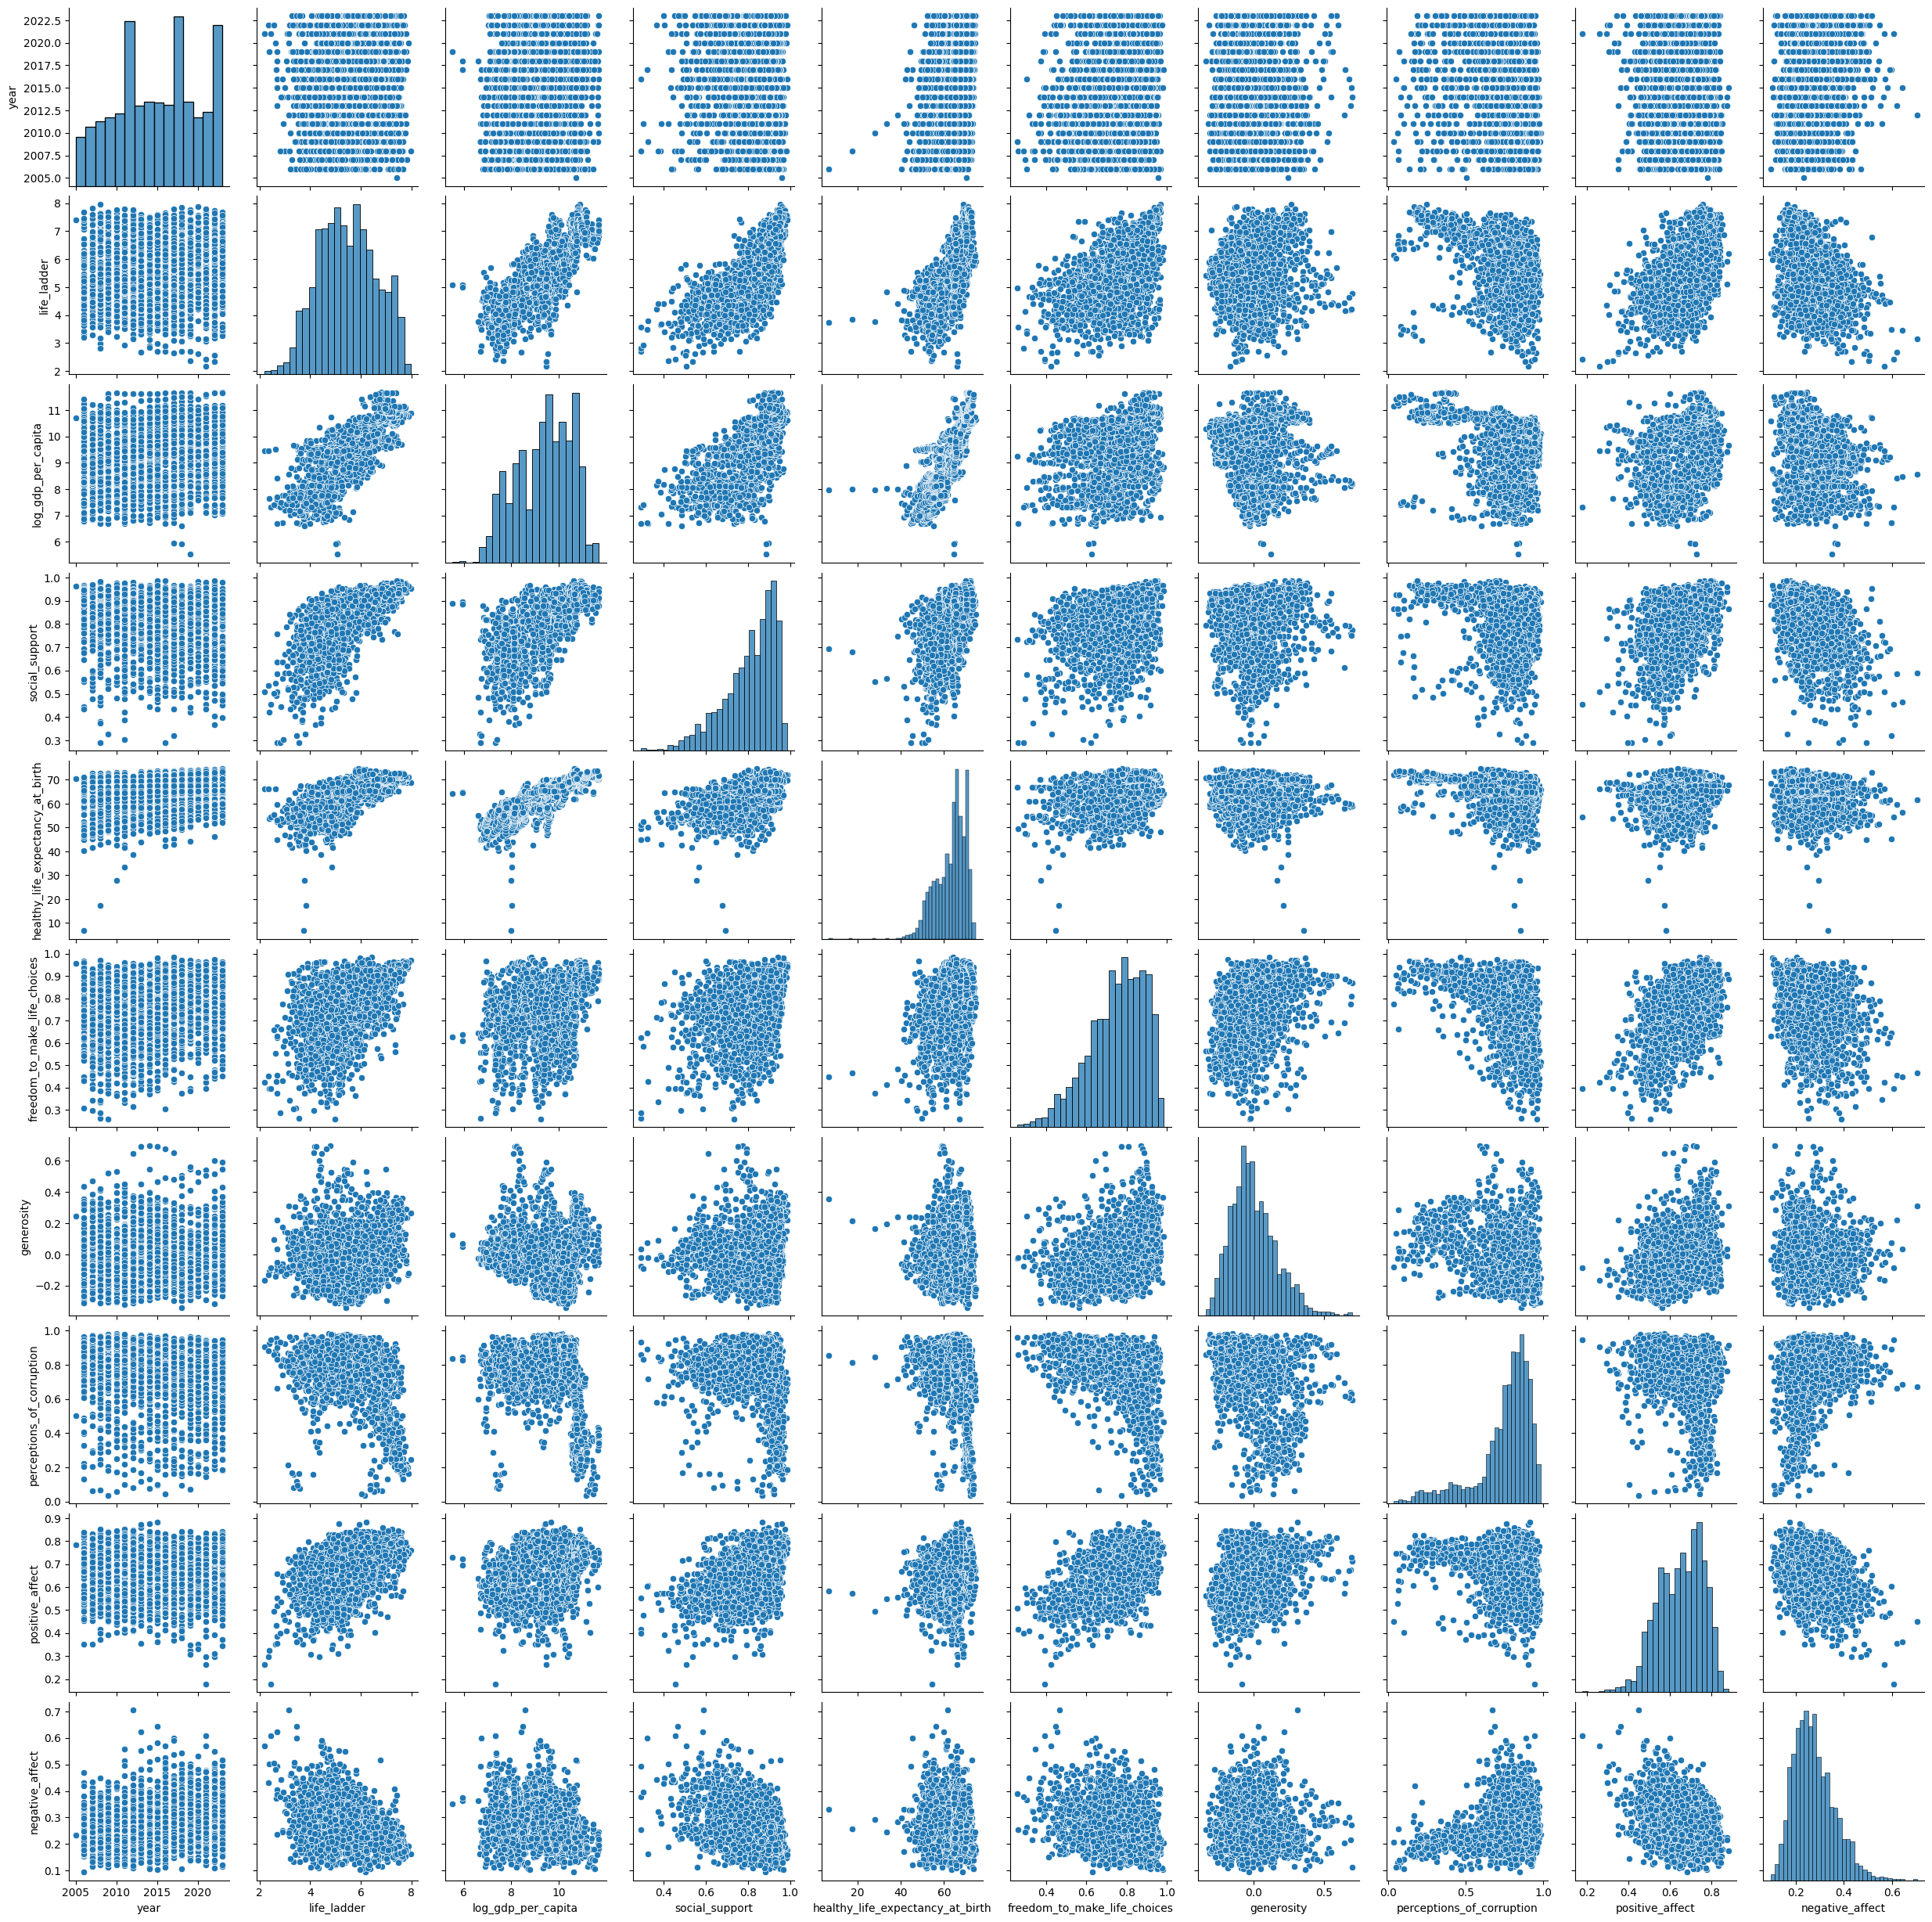

In [ ]:
sns.pairplot(df)

## Inspecting some correlations, & removing outliers

* In the original tutorial provided, it does not go through in-depth inspection regarding correlation, or outliers. 

1. For outliers, for each of features we are removing rows which are deviating Q1~Q3 iqr.
2. After that, we are inspecting correlations between each variables

In [ ]:
# Define functions to easily remove outliers.
def iqr_threashold(df, colname): 
    q1 = df[colname].quantile(0.25)
    q3 = df[colname].quantile(0.75)
    iqr = q3-q1
    
    min = q1-1.5*iqr
    max = q3+1.5*iqr
    return (min, max)

def check_outliers(df, colname):
    iqr_min, iqr_max = iqr_threashold(df, colname)[0], iqr_threashold(df, colname)[1]
    
    return df[(df[colname] < iqr_min) | (df[colname] > iqr_max)].shape[0]

def filter_for_column(df, colname):
    
    iqr_min, iqr_max = iqr_threashold(df, colname)[0], iqr_threashold(df, colname)[1]
    
    return df[(df[colname] >= iqr_min) & (df[colname] <= iqr_max)]

In [ ]:
outlier_columns = [
    i for i in df.columns 
    if np.issubdtype(df[i].dtype, np.number)  # Check if the column is numeric
    and check_outliers(df, i) >= 0  # Check for outliers
    and i not in ["country_name", "year"]  # Exclude specific columns
]

In [ ]:
temp = df
for i in outlier_columns:
    temp = filter_for_column(temp, i)

df = temp

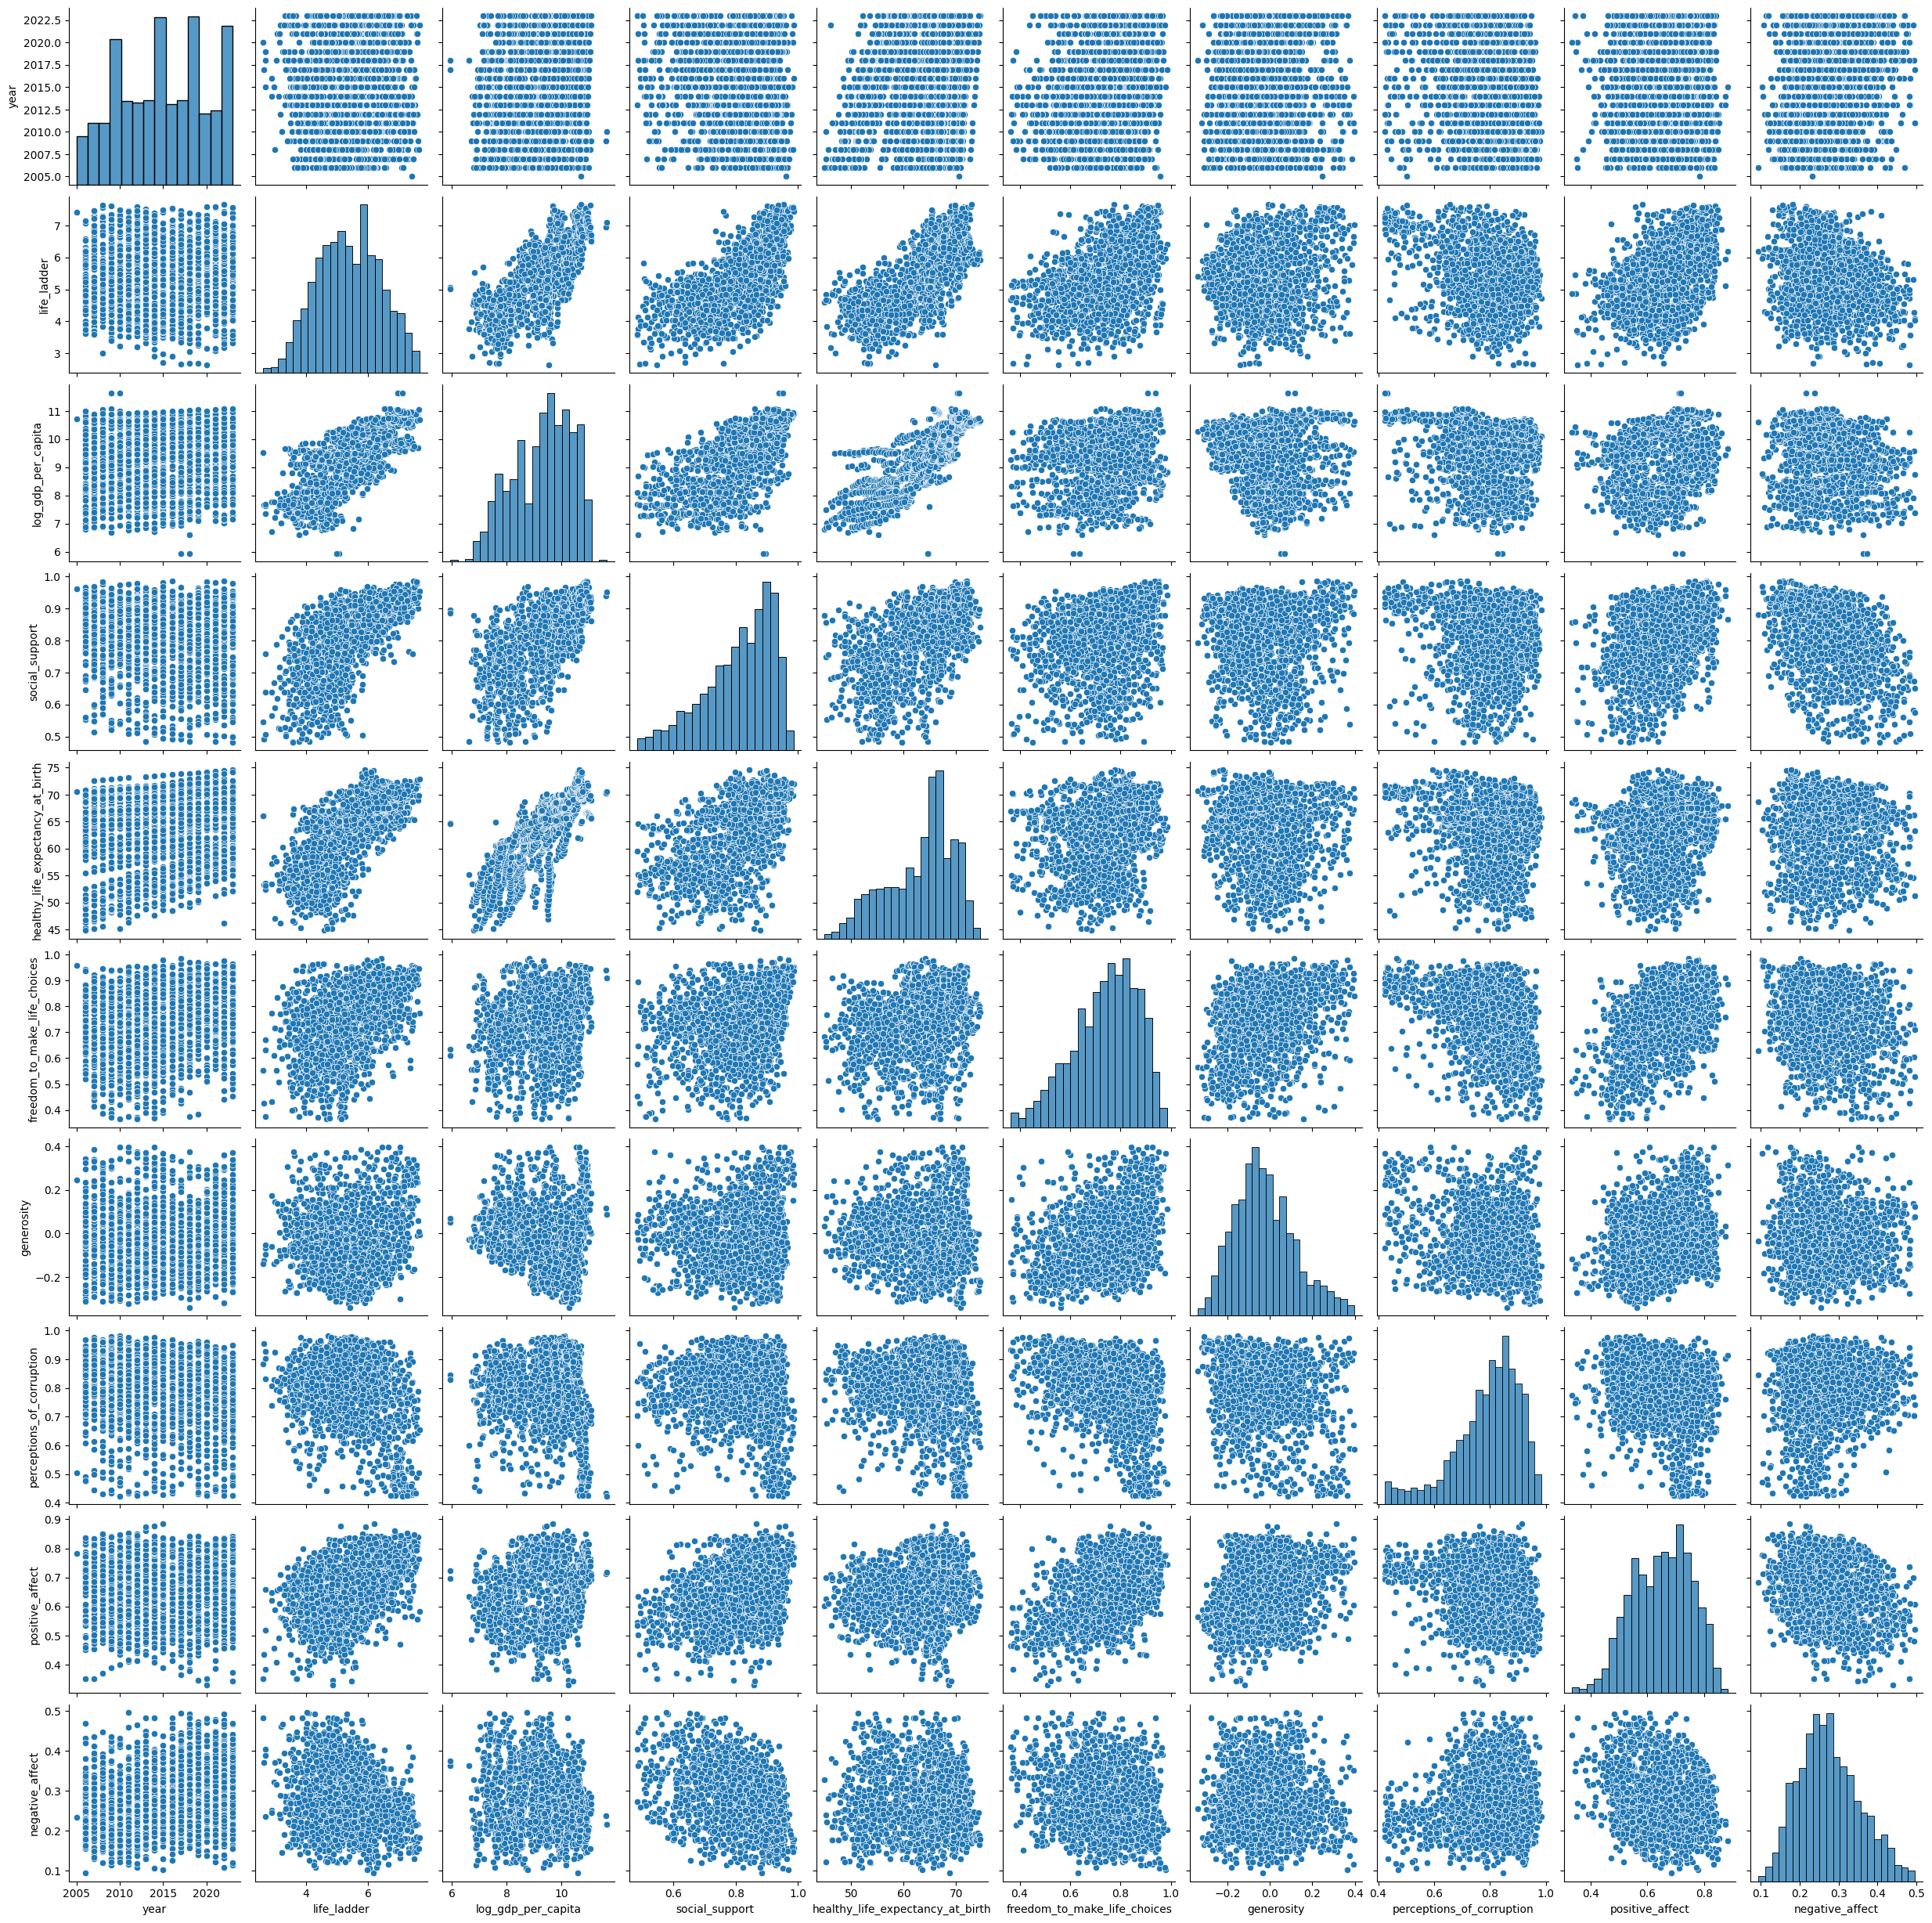

In [ ]:
#Check plot with  outliers
sns.pairplot(df)

In [ ]:
correlations = df.corr().drop(index = "year", columns= "year")

In [ ]:
correlations[feature]

life_ladder                        -0.231941
log_gdp_per_capita                 -0.185986
social_support                     -0.410931
healthy_life_expectancy_at_birth   -0.053742
freedom_to_make_life_choices       -0.164654
generosity                         -0.032546
perceptions_of_corruption           0.142611
positive_affect                    -0.227510
negative_affect                     1.000000
Name: negative_affect, dtype: float64

In [ ]:
# Get some highlights
corr = {}
for feature in correlations.columns:
    corr[feature] = dict(correlations[feature][((correlations[feature] >= 0.7) | (correlations[feature] <= -0.7)) & (correlations[feature] != 1)])


In [ ]:
corr

{'life_ladder': {'log_gdp_per_capita': 0.7459340901989036,
  'healthy_life_expectancy_at_birth': 0.7141190001571981},
 'log_gdp_per_capita': {'life_ladder': 0.7459340901989036,
  'healthy_life_expectancy_at_birth': 0.8354173024798083},
 'social_support': {},
 'healthy_life_expectancy_at_birth': {'life_ladder': 0.7141190001571981,
  'log_gdp_per_capita': 0.8354173024798083},
 'freedom_to_make_life_choices': {},
 'generosity': {},
 'perceptions_of_corruption': {},
 'positive_affect': {},
 'negative_affect': {}}

# Try Linear Regression, and compare with MLE

In [ ]:
y = df['healthy_life_expectancy_at_birth'].values

X = df[['log_gdp_per_capita', 'social_support',
        'freedom_to_make_life_choices', 'generosity', 'perceptions_of_corruption',
        'positive_affect', 'negative_affect']].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## MLE - Linear model definition

For each data point $i$, we could write the model:

$$ 
y_i = \theta_0 + \theta_1x_{i1} ... \theta_1x_{ik}
$$

Coefficients we are estimating are $\theta$

Log likelihood is formulated as:

$$
L(\mu, \sigma ; x) = \prod\limits_{i=1}^n f_{X_i}(x_i) = \prod\limits_{i=1}^n \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{(x_i-\mu)}{\sigma})^2}
$$

taking log: 

$$
log(L(\mu, \sigma ; x)) = -log(\sigma^n(\sqrt{2\pi})^n) -\frac{1}{2}(\frac{\sum_{i=1}^n(x_i-\mu)^2}{\sigma^2}) \\
= -\frac{n}{2}log(2\pi)-nlog(\sigma) - \frac{1}{2}(\frac{\sum_{i=1}^n(x_i-\mu)^2}{\sigma^2})
$$

## Bayesian approach to get MLE for linear model
Likelihood we need to maximize is:
$$
P(Data | Model) * P(Model)
$$

In case of Linear model prediction, we could re-formulated this one.
We can assume that $\theta$ are from standard normal.

Therefore, we can write $P(Model)$ as, putting $\theta$ into the PDF of standard normal and multiplying them:

$$
\prod\limits_i \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}\theta_i^2}
$$


For $P(Data | Model)$, when a model (a linear model) is given and if we say error ($d_i = \hat{y_i}-y_i$) is also from Standard Normal, which means

$$
d_i \sim N(0, 1)
$$

WE can represent the liklihood ($P(Data | Model)$) as :
$$
\prod\limits_i \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}d_i^2}
$$

Therefore, the final log likelihood we need to maximizing could be:

$$
log(\prod\limits_i \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}\theta_i^2}) + \\
log(\prod\limits_i \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}d_i^2})\\

= -\frac{1}{2}(\sum d_i^2) -\frac{1}{2}(\sum \theta_i^2) \\
$$

Which is minimizing $\sum d_i^2 + \sum \theta_i^2$

where $d_i$ are errors, and squared sum of $\theta$ are regularization term.

Since $d_i$ are errors, it could be represented as:

$$
d_i = y_i - \theta_0 - \sum\limits_{j=1}^k \theta_jx_{ij}
$$

The final log likelihood definition with regularization would be:

$$
logL(\theta, \sigma^2) = -\frac{n}{2}log(2\pi)-nlog(\sigma) \\
- \frac{1}{2\sigma^2}(\sum_{i=1}^n y_i - \theta_0 - \sum\limits_{j=1}^k \theta_jx_{ij})^2 -\frac{\lambda}{2}(\sum \theta_i^2)
$$

where $\lambda$ is a regularizing constant (weight)

In [ ]:
from scipy.optimize import minimize

def regularized_log_likelihood(params, X, y, lambda_reg):
    theta = params[:-1]
    sigma2 = params[-1]
    
    #Prediction
    y_pred = np.dot(X, theta)
    #You can also to X @ beta
    
    # Log-likelihood
    n = len(y)
    log_likelohood = -n/2 * np.log(2 * np.pi * sigma2) - 1/(2 * sigma2) * np.sum((y - y_pred)**2)
    
    # Reg
    reg_term = (lambda_reg / 2) * np.sum(theta[1:]**2)
    
    
    return -(log_likelohood - reg_term)
    

We have $\theta_0$, so...

In [ ]:
X_train = np.column_stack((np.ones(X_train.shape[0]), X_train))

In [ ]:
lambda_reg = 0.1
initial_guess = np.ones(X_train.shape[1]+1)

result = minimize(regularized_log_likelihood, initial_guess, args=(X_train, y_train, lambda_reg))

/Users/HongSukhyun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/Users/HongSukhyun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/Users/HongSukhyun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [ ]:
theta_hat = result.x[:-1]
sigma2_hat = result.x[-1]

In [ ]:
print("Estimated coefficients (beta):", theta_hat)
print("Estimated variance (sigma^2):", sigma2_hat)

Estimated coefficients (beta): [ 970.53325709 9099.00913323  790.38500649  724.21625156  -20.7510722
  765.86374857  632.8961084   269.52857359]
Estimated variance (sigma^2): -2389.92684941922


In [ ]:
## Evaluation
X_test = np.column_stack((np.ones(X_test.shape[0]), X_test))
y_test_pred = np.dot(X_test, theta_hat)

In [ ]:
from sklearn.metrics import mean_squared_error

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

In [ ]:
print ("Test set RMSE: ",rmse_test)

Test set RMSE:  88024.95020951066


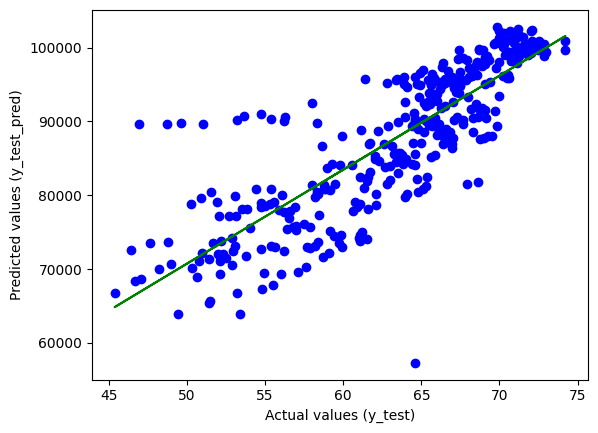

In [ ]:
plt.scatter(y_test, y_test_pred, color='blue', label='Predicted vs Actual')
plt.xlabel('Actual values (y_test)')
plt.ylabel('Predicted values (y_test_pred)')

coeffs = np.polyfit(y_test, y_test_pred, 1)  # Polyfit and polyval: yse leaast square method to fit polynomial data to linear
y_test_pred_line = np.polyval(coeffs, y_test)
plt.plot(y_test, y_test_pred_line, color='green', label='Regression line')
